# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [ ]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python -q

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.7 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`. (U OTRA)

2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [ ]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-12 19:11:57--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-12 19:11:57--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   358MB/s    in 0.2s    

2025-05-12 19:11:57 (358 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [ ]:
!wget https://p1.pikrepo.com/preview/127/95/812/love-couple-two.jpg

--2025-05-12 19:17:38--  https://p1.pikrepo.com/preview/127/95/812/love-couple-two.jpg
Resolving p1.pikrepo.com (p1.pikrepo.com)... 172.67.189.4, 104.21.43.238, 2606:4700:3035::ac43:bd04, ...
Connecting to p1.pikrepo.com (p1.pikrepo.com)|172.67.189.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121214 (118K) [image/jpeg]
Saving to: ‘love-couple-two.jpg.10’

love-couple-two.jpg 100%[===================>] 118.37K  --.-KB/s    in 0.003s  

2025-05-12 19:17:38 (38.0 MB/s) - ‘love-couple-two.jpg.10’ saved [121214/121214]



In [ ]:
image_path = "love-couple-two.jpg"
image_bgr = cv2.imread(image_path)

## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

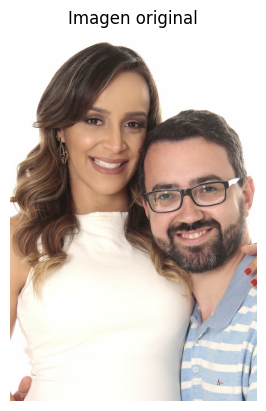

In [ ]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Imagen original")
plt.axis("off")
plt.show()


### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

In [ ]:
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

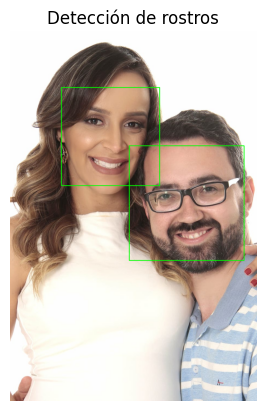

In [ ]:
# Detección con cascada Haar
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

image_rgb_con_rectangulos = image_rgb.copy()

for (x, y, w, h) in faces:
    cv2.rectangle(image_rgb_con_rectangulos, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(image_rgb)
plt.title("Detección de rostros")
plt.axis("off")
plt.show()


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

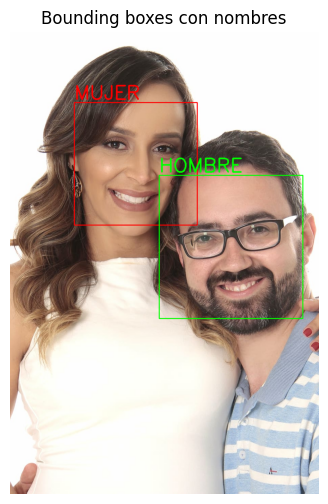

In [75]:
# Copiar la imagen para dibujar sobre ella
image_faces = image_rgb.copy()

# Asignar colores y nombres
colores = [(255, 0, 0), (0, 255, 0)]
nombres = ["MUJER", "HOMBRE"]

# Dibujar bounding boxes y nombres
for i, (x, y, w, h) in enumerate(faces):
    cv2.rectangle(image_faces, (x, y), (x+w, y+h), colores[i], 2)
    cv2.putText(image_faces, nombres[i], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                1.9, colores[i], 4)

# Mostrar imagen
plt.figure(figsize=(10, 6))
plt.imshow(image_faces)
plt.title("Bounding boxes con nombres")
plt.axis("off")
plt.show()


## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

In [ ]:
# Cargar el detector de landmarks y aplicarlo

if gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(gray, faces)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 2 rostro(s).


### 2.2 Procesar y Visualizar Landmarks (Pauls)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Pauls) y los dibujamos.

Landmarks MUJER procesados. Forma: (68, 2)

Dibujando landmarks de MUJER (rojo):

Zoom en MUJER:


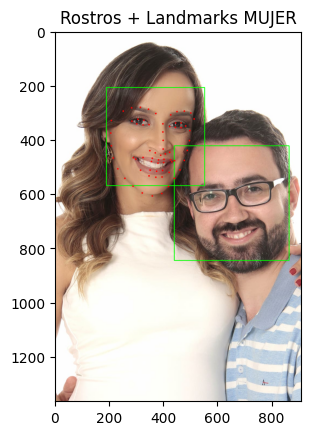

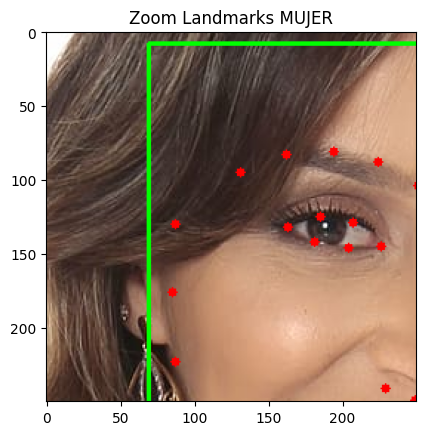

In [ ]:
# Procesar y dibujar landmarks de MUJER

image_rgb_contorno_mujer = image_rgb.copy()


if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_MUJER = all_landmarks[0]
  # Quitar dimensión extra y convertir a enteros
  landmarks_MUJER = landmarks_MUJER[0].astype(int)
  print("Landmarks MUJER procesados. Forma:", landmarks_MUJER.shape) # Debe ser (68, 2)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de MUJER (rojo):")
  for x, y in landmarks_MUJER:
      cv2.circle(image_rgb_contorno_mujer, (x, y), 0, (255, 0, 0), 5) # Radio 0, grosor 1 para punto pequeño
  plt.imshow(image_rgb_contorno_mujer)
  plt.title("Rostros + Landmarks MUJER")

  # Mostrar zoom
  print("\nZoom en MUJER:")
  plt.figure()
  plt.imshow(image_rgb_contorno_mujer[200:450, 120:370])
  plt.title("Zoom Landmarks MUJER")

else:
  print("No hay landmarks disponibles para procesar.")

### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (Darín)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

Landmarks HOMBRE procesados. Forma: (68, 2)

Dibujando landmarks de HOMBRE (verde):

Zoom en HOMBRE:


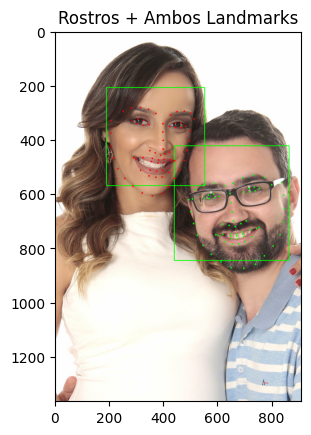

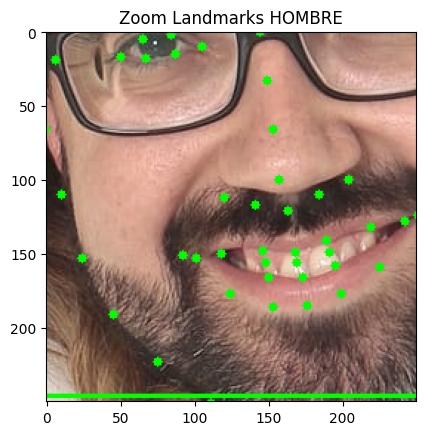

In [ ]:
# Solución Ejercicio 5 (Procesar y dibujar landmarks cara 2)
image_rgb_contorno_HOMBRE = image_rgb_contorno_mujer.copy()

if all_landmarks is not None and len(all_landmarks) >= 2:
  # Procesar landmarks Darín (indice 1)
  landmarks_HOMBRE = all_landmarks[1]
  landmarks_HOMBRE = landmarks_HOMBRE[0].astype(int)
  print("Landmarks HOMBRE procesados. Forma:", landmarks_HOMBRE.shape)

  # Dibujar sobre la imagen 'img_rgb' existente
  print("\nDibujando landmarks de HOMBRE (verde):")
  for x, y in landmarks_HOMBRE:
      cv2.circle(image_rgb_contorno_HOMBRE, (x, y), 0, (0, 255, 0), 5)
  plt.imshow(image_rgb_contorno_HOMBRE)
  plt.title("Rostros + Ambos Landmarks")

elif all_landmarks is None:
  print("No hay landmarks disponibles.")
elif len(all_landmarks) < 2:
  print("Solo se detectó 1 rostro, no se pueden procesar landmarks para HOMBRE.")


Zoom en HOMBRE (usando contorno de la cara):


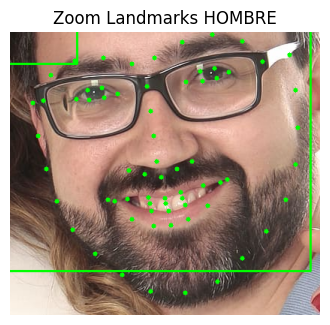

In [ ]:
# Extraer landmarks del contorno de la cara del hombre (índices 0 a 16)
contorno_cara_hombre = landmarks_HOMBRE[0:17]

# Calcular los límites de la región con un margen
x_min = max(contorno_cara_hombre[:, 0].min() - 30, 0)
x_max = contorno_cara_hombre[:, 0].max() + 30
y_min = max(contorno_cara_hombre[:, 1].min() - 30, 0)
y_max = contorno_cara_hombre[:, 1].max() + 30

# Mostrar zoom basado en el contorno facial
print("\nZoom en HOMBRE (usando contorno de la cara):")
plt.figure(figsize=(4, 4))
plt.imshow(image_rgb_contorno_HOMBRE[y_min:y_max, x_min:x_max])
plt.title("Zoom Landmarks HOMBRE")
plt.axis("off")
plt.show()

## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Pauls)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_pauls`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

Ojos y Boca MUJER


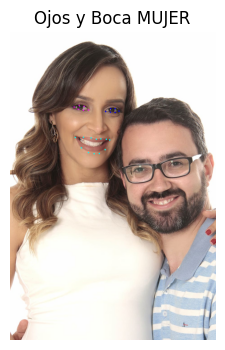

In [ ]:
### 3.1 Ejercicio 6: Dibujar Ojos y Boca (Pauls)

# 1. Definir listas con los índices de los landmarks que corresponden a:
#    - ojo izquierdo: puntos 36 a 41
#    - ojo derecho: puntos 42 a 47
#    - boca (exterior): puntos 48 a 59
ojo_izquierdo = [36, 37, 38, 39, 40, 41]
ojo_derecho = [42, 43, 44, 45, 46, 47]
boca = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

# 2. Crear copia limpia de la imagen BGR original convertida a RGB
img_con_partes = cv2.cvtColor(image_bgr.copy(), cv2.COLOR_BGR2RGB)

# 3. Iterar sobre los landmarks de Pauls (la mujer)
#    Asegurarse de que estén en formato (68, 2) con enteros
for i, (x, y) in enumerate(landmarks_MUJER):
    # 4. Dibujar solo los puntos de ojos y boca con diferentes colores
    if i in ojo_izquierdo:
        cv2.circle(img_con_partes, (x, y), 3, (255, 0, 255), -1)  # Magenta
    elif i in ojo_derecho:
        cv2.circle(img_con_partes, (x, y), 3, (0, 0, 255), -1)    # Azul
    elif i in boca:
        cv2.circle(img_con_partes, (x, y), 3, (0, 255, 255), -1)  # Cian

print("Ojos y Boca MUJER")
plt.figure(figsize=(4, 4))
plt.imshow(img_con_partes)
plt.title("Ojos y Boca MUJER")
plt.axis("off")
plt.show()


Zoom en BOCA de MUJER:


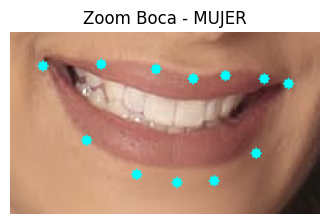

In [ ]:
# 5. Mostrar zoom en la boca, usando coordenadas de sus landmarks

# Extraer coordenadas de la boca (índices 48 a 59)
boca_coords = landmarks_MUJER[boca]

# Calcular límites del recorte
x_min = max(boca_coords[:, 0].min() - 20, 0)
x_max = boca_coords[:, 0].max() + 20
y_min = max(boca_coords[:, 1].min() - 20, 0)
y_max = boca_coords[:, 1].max() + 20

print("\nZoom en BOCA de MUJER:")
plt.figure(figsize=(4, 4))
plt.imshow(img_con_partes[y_min:y_max, x_min:x_max])
plt.title("Zoom Boca - MUJER")
plt.axis("off")
plt.show()


## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.

In [71]:
from scipy.spatial import distance as dist

def calcular_ear(landmarks, ojo_indices):
    # Extraer los 6 puntos del ojo
    p = landmarks[ojo_indices]
    # Calcular la fórmula del EAR
    ear = (dist.euclidean(p[1], p[5]) + dist.euclidean(p[2], p[4])) / (2.0 * dist.euclidean(p[0], p[3]))
    return ear

def calcular_mar(landmarks):
    # Puntos relevantes de la boca
    A = dist.euclidean(landmarks[51], landmarks[59])
    B = dist.euclidean(landmarks[53], landmarks[57])
    C = dist.euclidean(landmarks[49], landmarks[55])
    D = dist.euclidean(landmarks[48], landmarks[54])
    mar = (A + B + C) / (2.0 * D)
    return mar


In [73]:
# Calcular EAR para LA MUJER
ojo_izq_idx = [36, 37, 38, 39, 40, 41]
ojo_der_idx = [42, 43, 44, 45, 46, 47]

ear_izq = calcular_ear(landmarks_MUJER, ojo_izq_idx)
ear_der = calcular_ear(landmarks_MUJER, ojo_der_idx)
ear_promedio = (ear_izq + ear_der) / 2.0

# Calcular MAR
mar = calcular_mar(landmarks_MUJER)

print(f"EAR Promedio (MUJER): {ear_promedio:.3f}")
print(f"MAR (MUJER): {mar:.3f}")

# Evaluar somnolencia y bostezo en base a EAR y MAR
if ear_promedio < 0.25:
    print("⚠️ Posible somnolencia detectada (EAR bajo)")
else:
    print("✔️ Ojos abiertos normalmente (EAR aceptable)")

if mar > 0.6:
    print("😮 Posible bostezo detectado (MAR alto)")
else:
    print("✔️ Boca cerrada normalmente (MAR aceptable)")



EAR Promedio (MUJER): 0.275
MAR (MUJER): 0.888
✔️ Ojos abiertos normalmente (EAR aceptable)
😮 Posible bostezo detectado (MAR alto)
